## 1. Imports

In [1]:
from autograd import numpy as np
from autograd import grad
import matplotlib.pyplot as plt
from tqdm import tqdm
np.random.seed(0)
%matplotlib inline

## 2. Define system

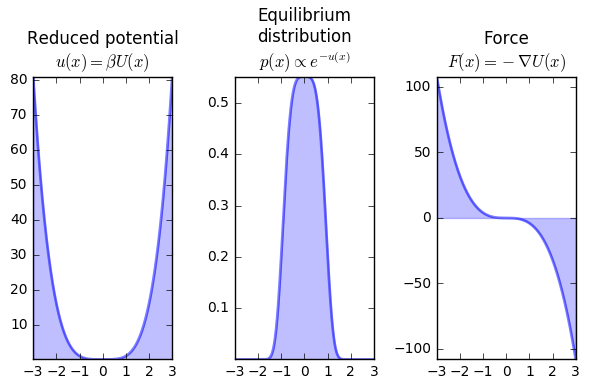

In [2]:
beta = 1.0 # inverse temperature

def potential(x): return x**4
def reduced_potential(x): return potential(x) * beta
def log_q(x): return - reduced_potential(x)
def q(x): return np.exp(log_q(x))
def force(x): return - grad(potential)(x)

# normalized density
x = np.linspace(-3,3,1000)
Z = np.trapz(map(q, x), x)
def p(x): return q(x) / Z

def plot(x, y, color='blue', padding=0):
    plt.plot(x, y, alpha=0.5, linewidth=2,color=color)
    plt.fill_between(x,y,alpha=0.25,color=color)
    span = max(y) - min(y)
    plt.ylim(min(y) - padding*span, max(y) + padding*span)

plt.subplot(1,3,1)
plot(x, map(reduced_potential, x))
plt.title('Reduced potential\n$u(x)=\\beta U(x)$')

plt.subplot(1,3,2)
plot(x, map(p, x))
plt.title('Equilibrium\ndistribution\n$p(x)\propto e^{-u(x)}$')

plt.subplot(1,3,3)
plot(x, map(force, x))
plt.title('Force\n$F(x)=-\\nabla U(x)$')

plt.tight_layout()

## 3. Define stochastic dynamics

In [3]:
# example initial conditions
x_0, v_0 = 0, 1

m = 1.0 # mass
velocity_scale = np.sqrt(1 / (beta * m))

def draw_velocities():
    return velocity_scale * np.random.randn(*np.ones_like(v_0).shape)
    
def kinetic_energy(v):
    return np.sum(0.5 * m * v**2)

def total_energy(x, v):
    return kinetic_energy(v) + potential(x)

def A_map(x, v, h): # linear "drift"
    x_ = x + (h * v) 
    v_ = v
    return x_, v_

def B_map(x, v, h): # linear "kick"
    x_ = x
    v_ = v + (h * force(x) / m)
    return x_, v_

def O_map(x, v, h, gamma): # Ornstein-Uhlenbeck
    x_ = x
    b = np.exp(-gamma * h)
    v_ = (b * v) + ((1 - b) * draw_velocities())
    return x_, v_

splitting_map = {'A': A_map, 'B': B_map, 'O': O_map}

def langevin_map(x, v, h, splitting):
    for step in splitting: x, v = splitting_map[step](x, v, h / sum([l==step for l in splitting]))
    return x, v

## 4. Track energy change per step of stochastic dynamics

In [8]:
# now, we just wrap each of the A, B, O updates with a couple lines to measure
# the energy difference during the substep
def bookkeeping_A_map(x, v, h, **kwargs):
    ''' deterministic position update '''
    x_, v_ = A_map(x, v, h)
    e_diff = potential(x_) - potential(x)
    return x_, v_, e_diff
    
def bookkeeping_B_map(x, v, h, **kwargs):
    ''' deterministic velocity update '''
    x_, v_ = B_map(x, v, h)
    e_diff = kinetic_energy(v_) - kinetic_energy(v)
    return x_, v_, e_diff

def bookkeeping_O_map(x, v, h, gamma, **kwargs):
    ''' stochastic velocity update'''
    x_, v_ = O_map(x, v, h, gamma)
    e_diff = kinetic_energy(v_) - kinetic_energy(v)
    return x_, v_, e_diff

bookkeeping_map = {'A': bookkeeping_A_map,
                   'B': bookkeeping_B_map,
                   'O': bookkeeping_O_map}

def bookkeeping_langevin_map(x, v, h, splitting, integrator_params=None):
    W_shad, Q = 0, 0
    for substep in splitting:
        h_substep = h / sum([l==substep for l in splitting])
        x, v, e_diff = bookkeeping_map[substep](x, v, h_substep, **integrator_params)
        if substep in 'AB': W_shad += e_diff
        else: Q += e_diff
    return x, v, W_shad, Q

def bookkeeping_langevin_factory(n_steps, splitting='BAOAB', integrator_params=None):
    def multistep_langevin(x, v, h, integrator_params):
        xs, vs = np.array([np.ones_like(x)]*n_steps), np.array([np.ones_like(v)]*n_steps)
        xs[0], xs[0] = x, v
        W_shad, Q = np.zeros(n_steps), np.zeros(n_steps)
        for i in tqdm(range(1, n_steps)):
            xs[i], vs[i], W_shad[i], Q[i] = \
                bookkeeping_langevin_map(xs[i-1], vs[i-1], h, splitting, integrator_params)
        return xs, vs, W_shad, Q
    return multistep_langevin

## 5. Simulate and visualize a couple trajectories

100%|██████████| 99999/99999 [00:26<00:00, 3744.81it/s]


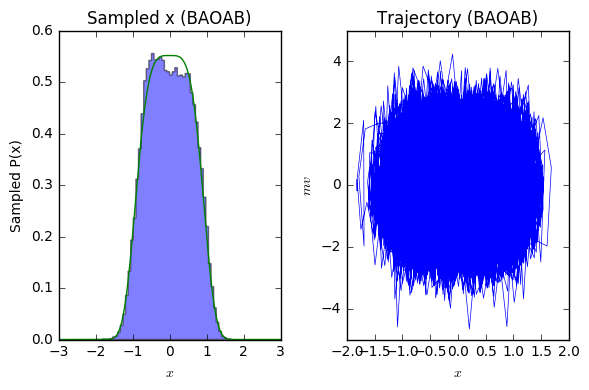

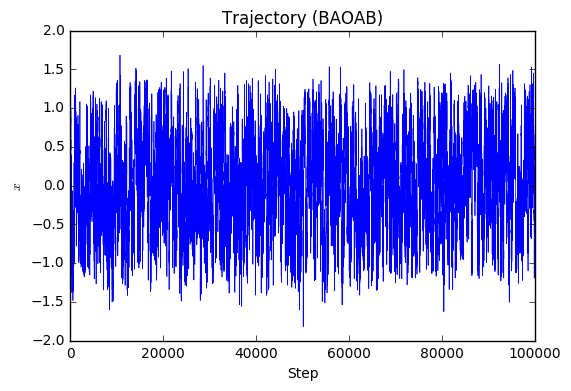

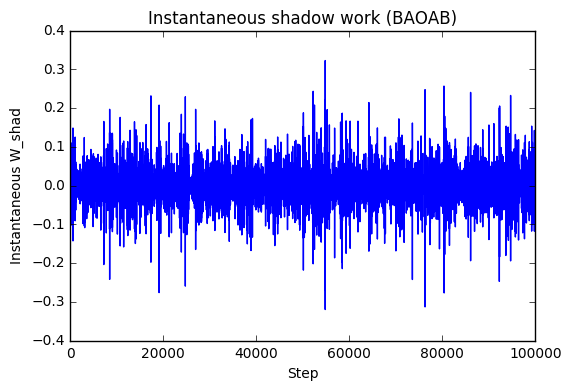

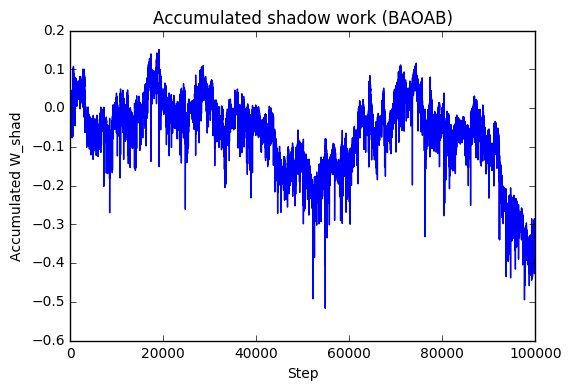

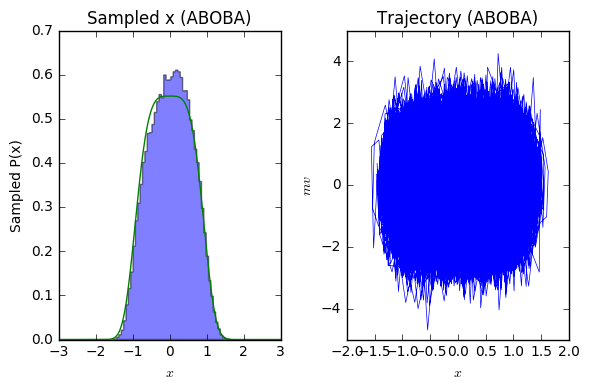

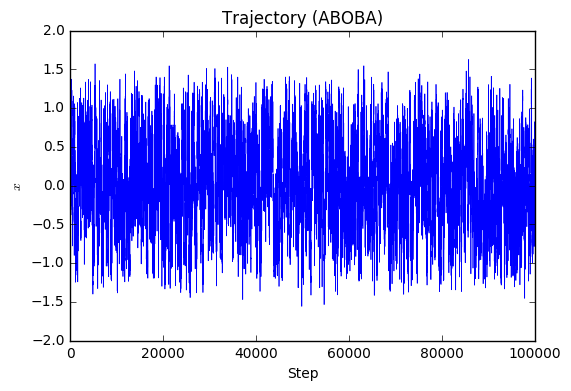

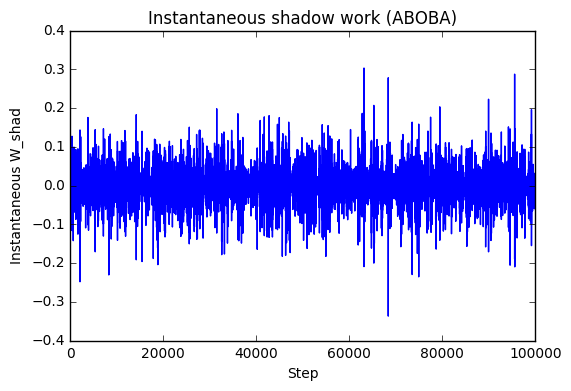

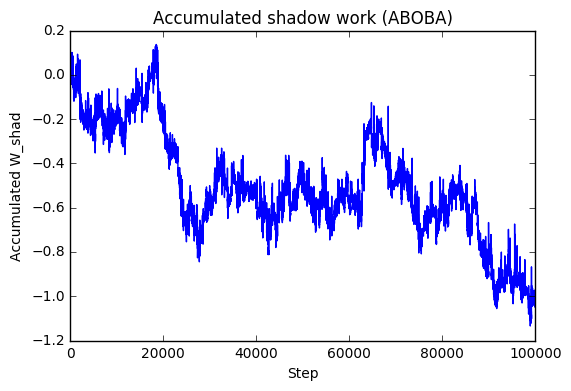

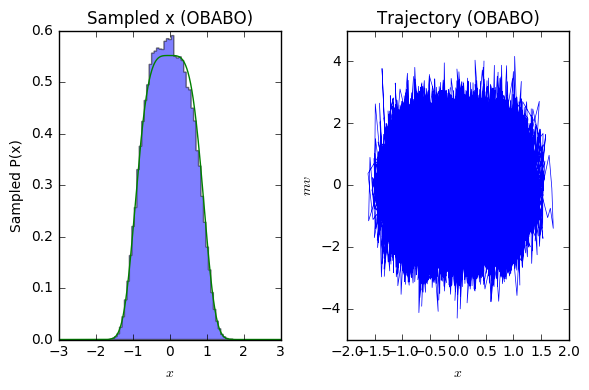

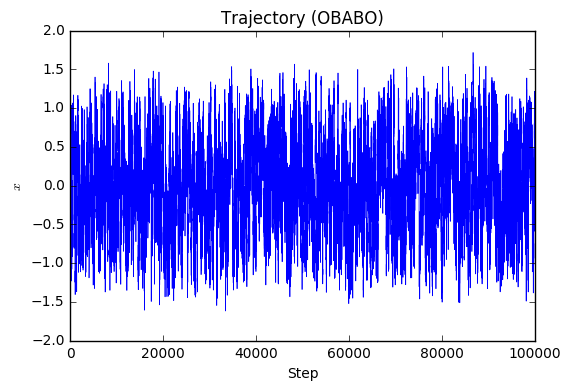

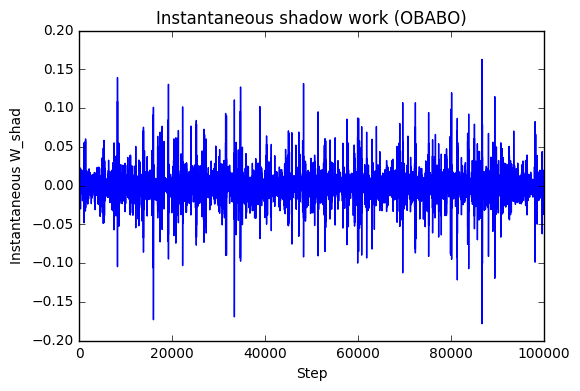

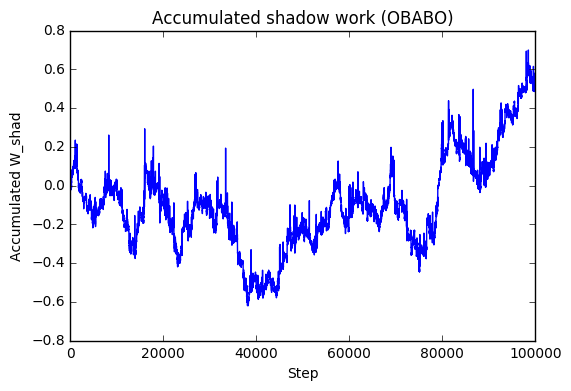

In [9]:
def test_scheme(x_0, v_0, n_steps, scheme, h, integrator_params):
    langevin = bookkeeping_langevin_factory(n_steps, scheme)
    xs, vs, W_shad, Q = langevin(x_0, v_0, h, integrator_params)
    
    # plot the x marginal
    plt.figure()
    plt.subplot(1,2,1)
    plt.title('Sampled x ({})'.format(scheme))
    plt.hist(xs, bins=50, normed=True, histtype='stepfilled', alpha=0.5);
    x = np.linspace(-3,3,1000)
    plt.plot(x, map(p, x))
    plt.xlabel(r'$x$')
    plt.ylabel('Sampled P(x)')
    
    # plot the trajectory
    plt.subplot(1,2,2)
    plt.title('Trajectory ({})'.format(scheme))
    plt.plot(xs, vs*m, linewidth=0.5)
    plt.xlabel(r'$x$')
    plt.ylabel(r'$mv$')
    
    plt.tight_layout()
    
    # plot the x trajectory
    plt.figure()
    plt.title('Trajectory ({})'.format(scheme))
    plt.plot(xs, linewidth=0.5)
    plt.xlabel('Step')
    plt.ylabel(r'$x$')
    
    # plot the instantaneous shadow work
    plt.figure()
    plt.plot(W_shad)
    plt.xlabel('Step')
    plt.ylabel('Instantaneous W_shad')
    plt.title('Instantaneous shadow work ({})'.format(scheme))
    
    # plot the accumulated shadow work
    plt.figure()
    plt.plot(np.cumsum(W_shad))
    plt.xlabel('Step')
    plt.ylabel('Accumulated W_shad')
    plt.title('Accumulated shadow work ({})'.format(scheme))
    
    return xs, vs, W_shad, Q

results = dict()
for scheme in 'BAOAB ABOBA OBABO'.split():
    results[scheme] = test_scheme(np.random.randn(), draw_velocities(),
                                  n_steps=int(1e5), scheme=scheme, h=1e-1,
                                  integrator_params = {'gamma':91.0}
                                 )

## 6. Confirm that bookkeeping is consistent

((100000,), (100000,))
((100000,), (100000,))
((100000,), (100000,))


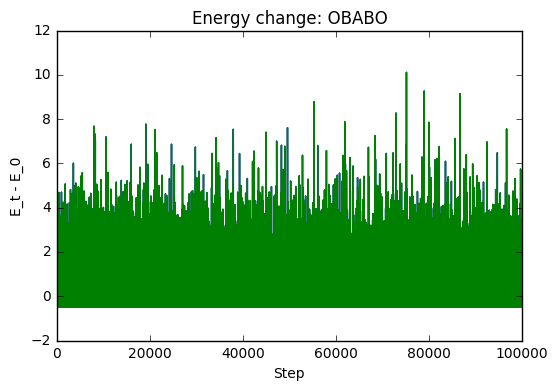

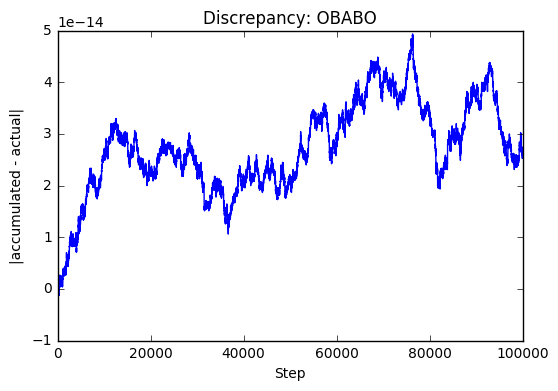

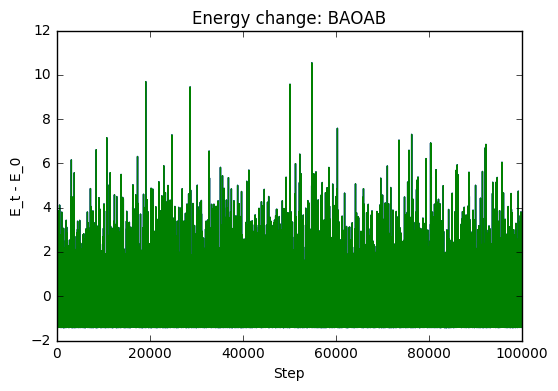

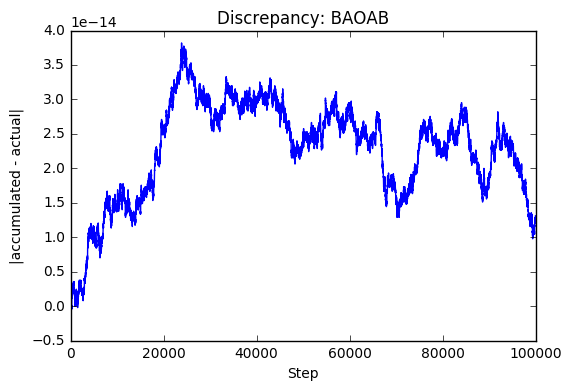

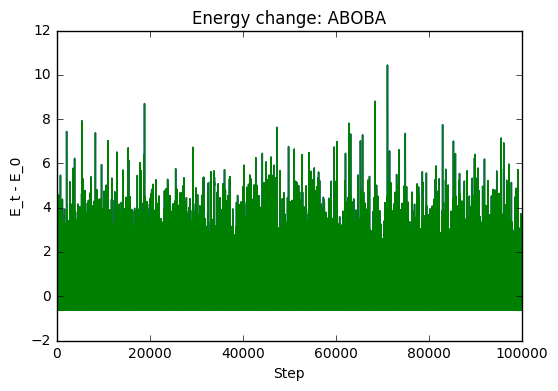

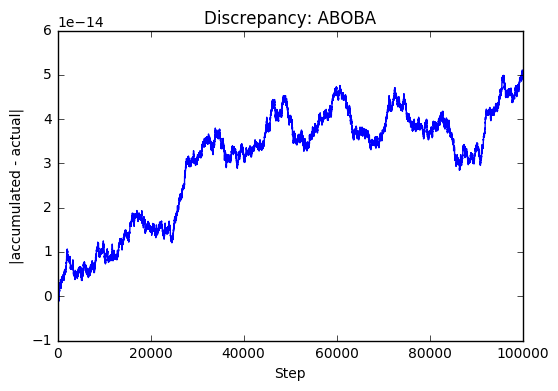

In [10]:
# let's confirm that energy change accumulated by the bookkeeper is the same as the
# actual energy change

def check_bookkeeping(results):
    for scheme in results:
        xs, vs, W_shad, Q = results[scheme]
        es = np.array([total_energy(xs[i],vs[i]) for i in range(len(xs))])

        # accumulated
        delta_e_bk = np.cumsum(W_shad + Q)
        accumulated = delta_e_bk - delta_e_bk[0]
        
        plt.figure()
        plt.title('Energy change: {}'.format(scheme))
        plt.xlabel('Step')
        plt.ylabel('E_t - E_0')
        plt.plot(accumulated, label='Stepwise bookkeeper')

        # actual
        actual = es - es[0]
        plt.plot(actual, label='Direct computation')

        # discrepancy
        plt.figure()
        discrepancy = accumulated - actual
        plt.plot(discrepancy)
        plt.title('Discrepancy: {}'.format(scheme))
        plt.xlabel('Step')
        plt.ylabel('|accumulated - actual|')

check_bookkeeping(results)